# 1B. Heterogeneity Classifier
___
**Author Contact:** <br>
Email: 
* [bcchang@utexas.edu](mailto:bcchang@utexas.edu) 
* [ali.mohamed@austin.utexas.edu](mailto:ali.mohamed@austin.utexas.edu)

This notebook demonstrates how we can use scale-independent porosity variance to classify a given sample as homogeneous or heterogeneous.

______

## 0. Import some packages

In [1]:
# DPM Tools functions
try:
    from dpm_tools.io import read_image
    from dpm_tools.metrics import heterogeneity_curve
    from dpm_tools.visualization import plot_heterogeneity_curve
except ModuleNotFoundError:
    !pip install --user dpm-tools
    from dpm_tools.io import read_image
    from dpm_tools.metrics import heterogeneity_curve
    from dpm_tools.visualization import plot_heterogeneity_curve

# Data processing packages
import numpy as np

# Image visualization packages
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Utility packages
from pathlib import Path

[13:43:05] ERROR    PARDISO solver not installed, run `pip install pypardiso`. Otherwise,          ]8;id=715258;file://c:\ProgramData\anaconda3\envs\agu24_workshop\Lib\site-packages\openpnm\utils\_workspace.py\_workspace.py]8;;\:]8;id=618606;file://c:\ProgramData\anaconda3\envs\agu24_workshop\Lib\site-packages\openpnm\utils\_workspace.py#56\56]8;;\
                    simulations will be slow. Apple M chips not supported.                                         

### Load and visualize data

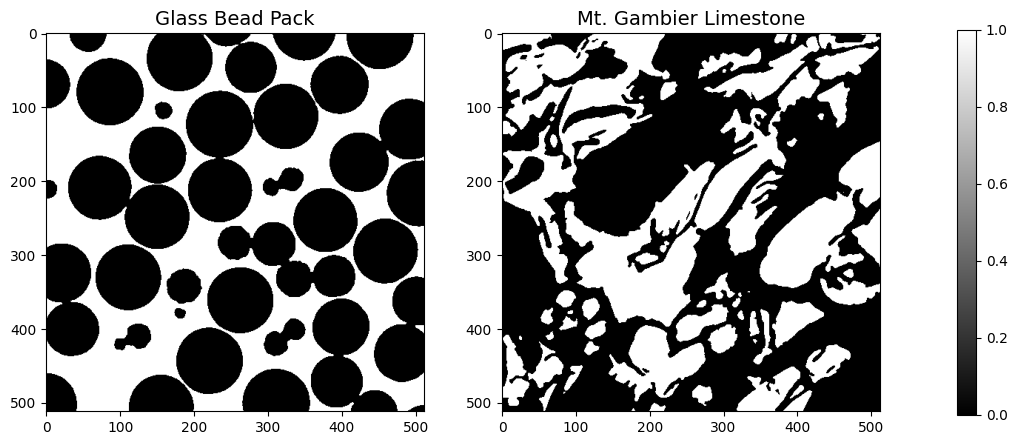

In [2]:
image_path = Path('../data')
beadpack, gambier = [read_image(image_path / (tif_img + '.tif')) for tif_img in ['beadpack', 'mtgambier']]

fig = plt.figure(figsize=(12, 5))
gs = GridSpec(1, 3, width_ratios=[1, 1, 0.05], wspace=0.3)

# Create subplots
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
cax = fig.add_subplot(gs[0, 2])


im1 = ax1.imshow(beadpack[0,:,:], cmap='gray')
im2 = ax2.imshow(gambier[0,:,:], cmap='gray')

fig.colorbar(im1, cax=cax)

ax1.set_title('Glass Bead Pack',fontsize=14)
ax2.set_title('Mt. Gambier Limestone',fontsize=14)

plt.show()

### Scale-independent Variance

Here we will compute the scale-independent porosity variance for both samples. The algorithm used is adopted from Mohamed and Prodanovic (2023) [[1]](#1).

The algorithm operates as follows:
    
1. The Euclidean distance transform is applied to the input binary image. The maximum value of the distance transform is used as the initial window size.
2. Select $n$ random locations throughout the image volume. Subsets at these locations are extracted using the initial window size.
3. Compute the porosity for each subset, then the porosity variance across all subset locations.
4. Increase the window size and repeat steps 2 & 3.
5. Each window size (radius) and porosity variance value is recorded for analysis.

This algorithm has been wrapped in a convenient function, ``heterogeneity_curve`` in the DPM Tools package.


In [3]:
results = {'beadpack': {}, 'gambier': {}}

results['beadpack']['radii'], results['beadpack']['variance'] = heterogeneity_curve(beadpack)
results['gambier']['radii'], results['gambier']['variance'] = heterogeneity_curve(gambier)


### Plot the Results

By plotting the porosity variance vs. window size, we can assess the heterogeneity of the sample. Here, "relative radius" refers to the number of window growth steps from the initial window size. We use relative radius rather than physical window size to maintain scale invariance.

The homogeneity and heterogeneity zones are defined by aggregating labeled data sampled from the Digital Rocks Portal and are fully defined in [[1]](#1).

As we would expect, the glass bead pack sample falls into the homogeneous zone whereas the Mt. Gambier limestone clearly falls mainly in the heterogeneity zone




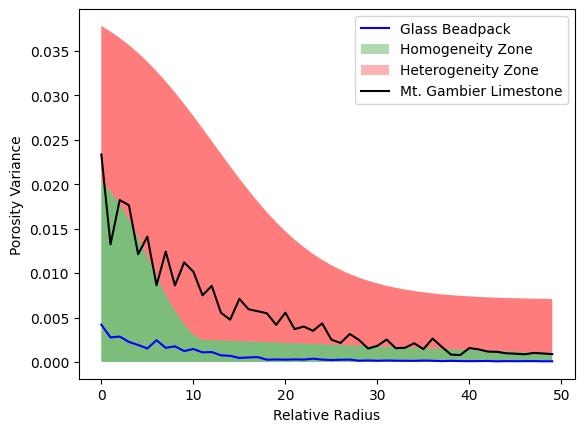

In [4]:
fig, ax = plot_heterogeneity_curve(results['beadpack']['radii'], results['beadpack']['variance'], color='blue', label='Glass Beadpack')
fig, ax = plot_heterogeneity_curve(results['gambier']['radii'], results['gambier']['variance'], fig=fig, ax=ax, color='black', label='Mt. Gambier Limestone')

plt.legend()
plt.show()

### Scoring the Result

Finally, we can score the result by computing the proportion of variance values that fall above the homogeneous/heterogeneous boundary. This is an indication of the *level* of heterogeneity in the sample. 

$$
\begin{align*}
&\text{score} \in [0, 1] \\[10pt]
&\text{score} = 
\begin{cases}
    0, & \text{if variance curve indicates completely homogeneous} \\
    1, & \text{if variance curve indicates completely heterogeneous} \\
\end{cases}
\end{align*}
$$

In [5]:
def sigmoid(x):
    """
    Sigmoid function
    """

    return 1 / (1 + np.exp(-x))

def heterogeneity_score(variances) -> float:
    """
    Assign a heterogeneity score to the heterogeneity curve based on the number of points above the homogeneous/heterogeneous threshold.
    
    Parameters:
    variances (np.ndarray): The porosity variance values from the heterogeneity curve
    
    Returns:
    float: The heterogeneity score for the given heterogeneity curve. 0 = homogeneous, 1 = heterogeneous
    """
    x = np.linspace(-2, 17, len(variances))
    bound = (0.023 * (1 - sigmoid(x)))
    bnd = bound[bound <= 0.0025]
    bound[bound <= 0.0025] = np.linspace(0.0025, 0.001, len(bnd))
    
    x2=np.linspace(-2, 6, len(variances))
    vv=((0.035 * (1 - sigmoid(x2)))) + 0.007
    wts = vv / vv.sum()
    
    r = wts * (variances > bound)

    return r.sum()

In [6]:
beadpack_score = heterogeneity_score(results['beadpack']['variance'])
gambier_score = heterogeneity_score(results['gambier']['variance'])

print(f"Heterogeneity Score for Glass Bead Pack: {beadpack_score :.3f}")

print(f"Heterogeneity Score for Mt. Gambier Limestone: {gambier_score:.3f}")

Heterogeneity Score for Glass Bead Pack: 0.000
Heterogeneity Score for Mt. Gambier Limestone: 0.744


## References

<a id="1">[1]</a> 
Mohamed, A. and Prodanovic, M. (2023). 
Scale-Independent Rock Heterogeneity Classification Algorithm Applied to Microtomography Images.
Transport in Porous Media, Volume 150, doi: [https://doi.org/10.1007/s11242-023-02008-1](https://doi.org/10.1007/s11242-023-02008-1)